In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor


In [104]:
# Veriyi yükleme
data = pd.read_excel('hackathon 2024 - Yapay Zeka.xlsx')


In [105]:
data.head()

,TIME_STAMP,SERVER_NAME,DOWNLOAD,UPLOAD
0,2024-03-05 18:25:00,10.0.901.xx Server 1,11927.017,424.700
1,2024-03-05 18:20:00,10.0.901.xx Server 1,19703.467,525.575
2,2024-03-05 18:15:00,10.0.901.xx Server 1,26349.663,631.144
3,2024-03-05 18:10:00,10.0.901.xx Server 1,26068.494,623.673
4,2024-03-05 18:05:00,10.0.901.xx Server 1,25814.357,620.701


In [106]:
print(data.dtypes)

TIME_STAMP     datetime64[ns]
SERVER_NAME            object
DOWNLOAD              float64
UPLOAD                float64
dtype: object


In [107]:
# Zaman damgasını datetime türüne dönüştürme
data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])
data.set_index('TIME_STAMP', inplace=True)

NOT: Tarih ve saat bilgilerini standart bir formatta işlemek için zaman damgalarını datetime türüne dönüştürüyoruz.tarihsel verilerle çeşitli analizler yapmayı kolaylaştırır.

In [108]:

# Veriyi temizleme (eksik değerleri kontrol etme)
print("Eksik değerler:\n", data.isnull().sum())

Eksik değerler:
 SERVER_NAME    0
DOWNLOAD       2
UPLOAD         2
dtype: int64


In [109]:
# Eksik değerleri içeren satırları kaldırma
data_cleaned = data.dropna()

# Temizlenmiş veriyi kontrol etme
print("Temizlenmiş veri eksik değerler:\n", data_cleaned.isnull().sum())



Temizlenmiş veri eksik değerler:
 SERVER_NAME    0
DOWNLOAD       0
UPLOAD         0
dtype: int64


In [111]:
# Eksik zaman damgalarını kontrol etme
full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='5T')  # 5 dakikalık frekansta zaman damgaları oluştur
data_complete = data.reindex(full_range)  # Eksik zaman damgalarını doldurma
# Eksik değerleri kontrol etme
print("Eksik değerler (yeni veri setinde):\n", data_complete.isnull().sum())

Eksik değerler (yeni veri setinde):
 SERVER_NAME    383
DOWNLOAD       385
UPLOAD         385
dtype: int64


In [112]:
# Eksik verileri işleme
data_complete = data_complete.interpolate(method='linear')  # Lineer interpolasyon ile doldurma


In [113]:
# Temizlenmiş veriyi kontrol etme
print("Temizlenmiş veri eksik değerler:\n", data_complete.isnull().sum())

Temizlenmiş veri eksik değerler:
 SERVER_NAME    383
DOWNLOAD         0
UPLOAD           0
dtype: int64


In [114]:
data_complete['SERVER_NAME'].fillna('Bilinmiyor', inplace=True)

# Temizlenmiş veriyi kontrol etme
print("Temizlenmiş veri eksik değerler:\n", data_complete.isnull().sum())

Temizlenmiş veri eksik değerler:
 SERVER_NAME    0
DOWNLOAD       0
UPLOAD         0
dtype: int64


In [115]:

# Ek Özellikler - Saat dilimlerine ayırma
data_complete['HOUR'] = data_complete.index.hour
data_complete['DAY_OF_WEEK'] = data_complete.index.dayofweek
data_complete['WEEKDAY'] = data_complete.index.to_period('W').astype(str)
data_complete['DATE'] = data_complete.index.date

In [116]:
# Saat dilimlerini belirleme (sabah, öğleden sonra, akşam)
def get_time_of_day(hour):
    if 0 <= hour < 6:
        return 'Gece'
    elif 6 <= hour < 12:
        return 'Sabah'
    elif 12 <= hour < 18:
        return 'Öğleden Sonra'
    else:
        return 'Akşam'

data_complete['TIME_OF_DAY'] = data_complete['HOUR'].apply(get_time_of_day)

In [117]:
data_complete.head()

,SERVER_NAME,DOWNLOAD,UPLOAD,HOUR,DAY_OF_WEEK,WEEKDAY,DATE,TIME_OF_DAY
2023-11-02 10:10:00,10.0.901.xx Server 1,14611.335,357.395,10,3,2023-10-30/2023-11-05,2023-11-02,Sabah
2023-11-02 10:15:00,10.0.901.xx Server 1,14336.298,355.811,10,3,2023-10-30/2023-11-05,2023-11-02,Sabah
2023-11-02 10:20:00,10.0.901.xx Server 1,14381.373,357.816,10,3,2023-10-30/2023-11-05,2023-11-02,Sabah
2023-11-02 10:25:00,10.0.901.xx Server 1,14461.797,358.717,10,3,2023-10-30/2023-11-05,2023-11-02,Sabah
2023-11-02 10:30:00,10.0.901.xx Server 1,14604.990,364.365,10,3,2023-10-30/2023-11-05,2023-11-02,Sabah


In [118]:
# Tarih ve saat dilimine göre veriyi ayırma
specific_date = '2024-03-05'
specific_time = '18:25:00'
specific_datetime = f"{specific_date} {specific_time}"
specific_timestamp = pd.to_datetime(specific_datetime)

In [119]:
# Veriyi haftaiçi ve hafta sonu olarak ayırma
is_weekday = specific_timestamp.weekday() < 5
time_of_day = get_time_of_day(specific_timestamp.hour)

In [120]:
if is_weekday:
    comparison_data = data_complete[(data_complete['DAY_OF_WEEK'] < 5) & (data_complete['HOUR'] == specific_timestamp.hour)]
else:
    comparison_data = data_complete[(data_complete['DAY_OF_WEEK'] >= 5) & (data_complete['HOUR'] == specific_timestamp.hour)]

In [121]:
# Tatil kontrolü için bir tatil listesi ekleme
holidays = pd.to_datetime(['2024-01-01', '2024-04-23', '2024-05-01', '2024-05-19', '2024-07-15', '2024-08-30', '2024-10-29']) 
is_holiday = specific_timestamp in holidays

In [125]:
print(f"Tarih: {specific_datetime}, Tatil mi: {is_holiday}")

Tarih: 2024-03-05 18:25:00, Tatil mi: False


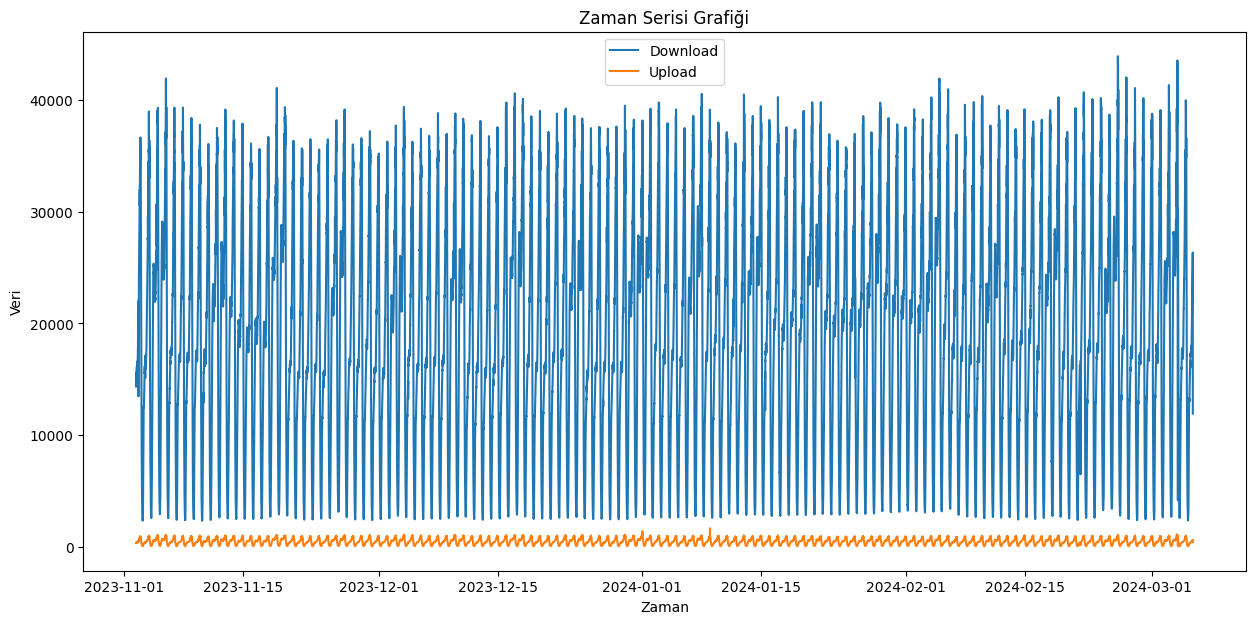

In [122]:
# Görselleştirme
plt.figure(figsize=(15, 7))
plt.plot(data_complete.index, data_complete['DOWNLOAD'], label='Download')
plt.plot(data_complete.index, data_complete['UPLOAD'], label='Upload')
plt.title('Zaman Serisi Grafiği')
plt.xlabel('Zaman')
plt.ylabel('Veri')
plt.legend()
plt.show()

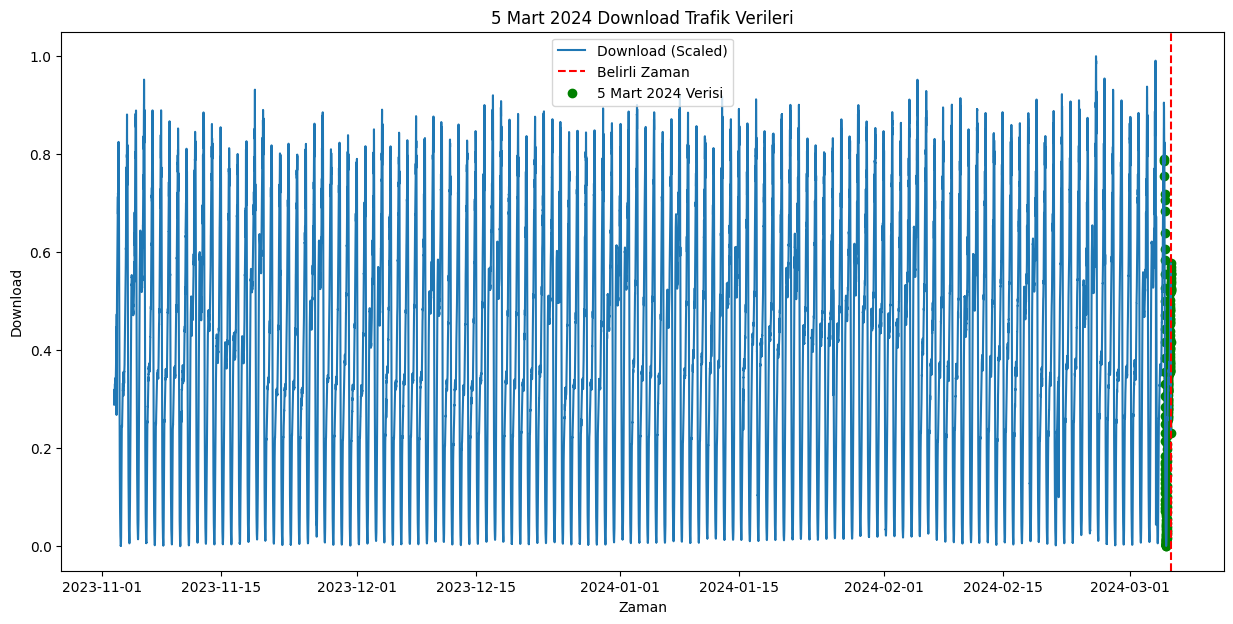

In [163]:
# Görselleştirme - Belirli Tarih ve Saat
plt.figure(figsize=(15, 7))
plt.plot(data_complete.index, data_complete['DOWNLOAD'], label='Download (Scaled)')
plt.axvline(x=specific_timestamp, color='red', linestyle='--', label='Belirli Zaman')
plt.scatter(data_complete.index[data_complete.index.date == pd.to_datetime(specific_date).date()], 
            data_complete['DOWNLOAD'][data_complete.index.date == pd.to_datetime(specific_date).date()], 
            color='green', label='5 Mart 2024 Verisi')
plt.title('5 Mart 2024 Download Trafik Verileri')
plt.xlabel('Zaman')
plt.ylabel('Download')
plt.legend()
plt.show()


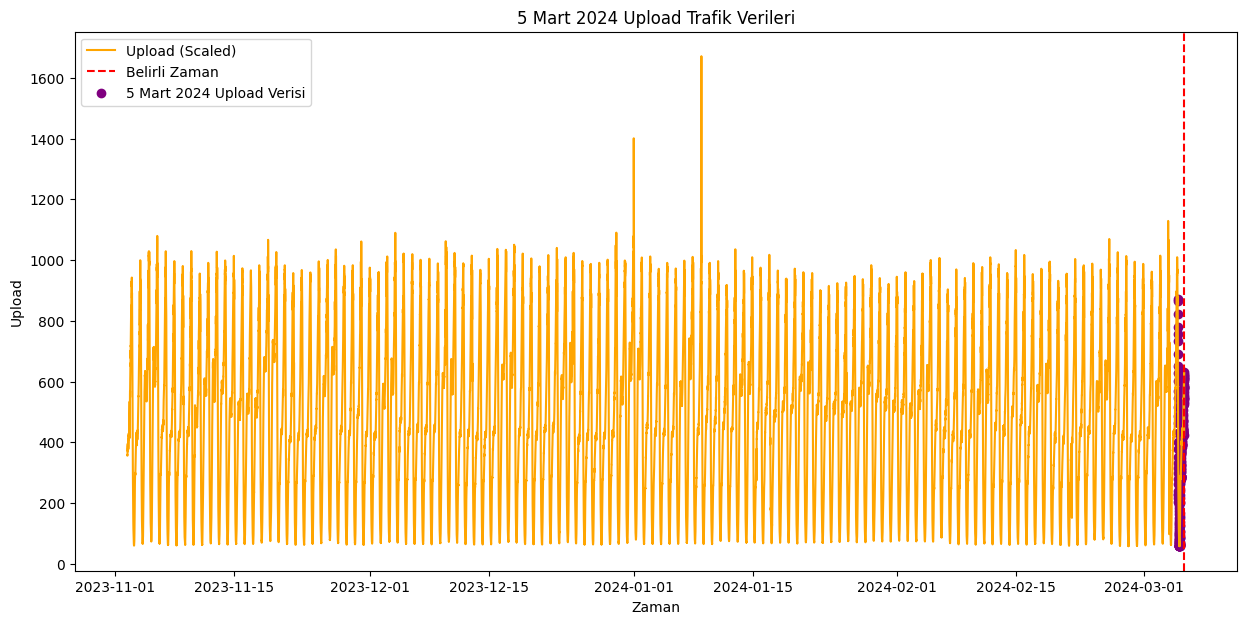

In [127]:
# Görselleştirme - Belirli Tarih ve Saat (Upload)
plt.figure(figsize=(15, 7))
plt.plot(data_complete.index, data_complete['UPLOAD'], label='Upload (Scaled)', color='orange')
plt.axvline(x=specific_timestamp, color='red', linestyle='--', label='Belirli Zaman')
plt.scatter(data_complete.index[data_complete.index.date == pd.to_datetime(specific_date).date()],
            data_complete['UPLOAD'][data_complete.index.date == pd.to_datetime(specific_date).date()],
            color='purple', label='5 Mart 2024 Upload Verisi')
plt.title('5 Mart 2024 Upload Trafik Verileri')
plt.xlabel('Zaman')
plt.ylabel('Upload')
plt.legend()
plt.show()

In [128]:
# Ölçekleme (Normalizasyon ve Standartizasyon)
scaler = MinMaxScaler()  # StandardScaler()
data_complete[['DOWNLOAD', 'UPLOAD']] = scaler.fit_transform(data_complete[['DOWNLOAD', 'UPLOAD']])

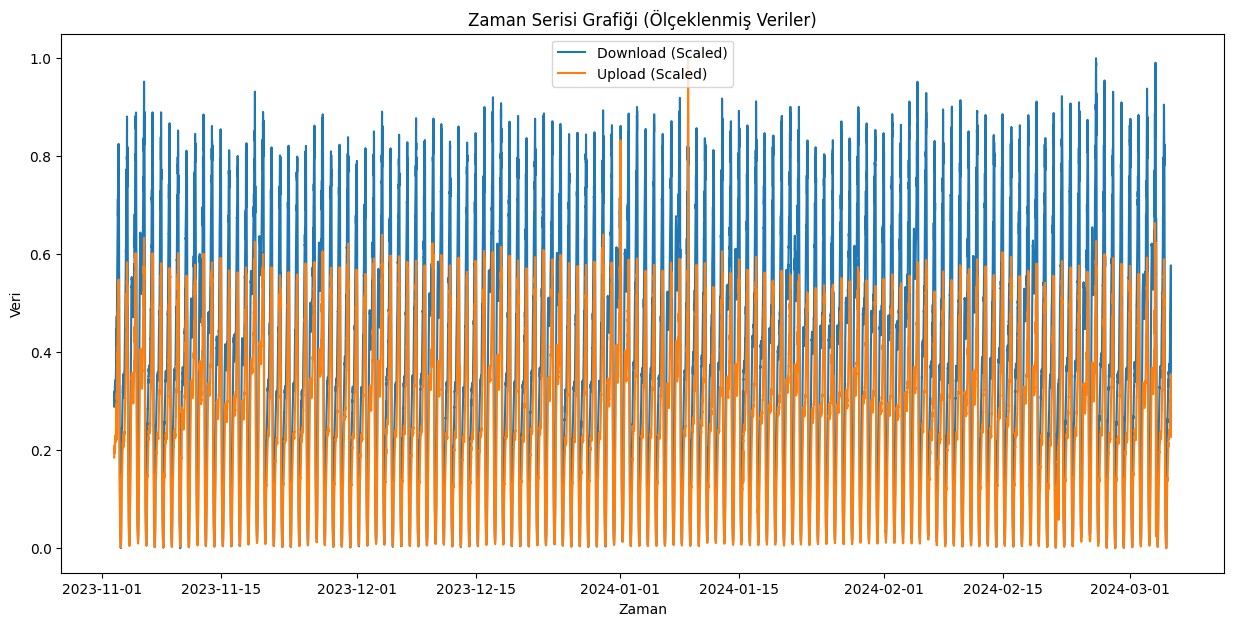

In [129]:
# Görselleştirme
plt.figure(figsize=(15, 7))
plt.plot(data_complete.index, data_complete['DOWNLOAD'], label='Download (Scaled)')
plt.plot(data_complete.index, data_complete['UPLOAD'], label='Upload (Scaled)')
plt.title('Zaman Serisi Grafiği (Ölçeklenmiş Veriler)')
plt.xlabel('Zaman')
plt.ylabel('Veri')
plt.legend()
plt.show()

In [130]:
# Eğitim ve Test Setlerine Ayırma
data_ml = data_complete[['DOWNLOAD', 'UPLOAD']].copy()
X = data_ml
y = np.zeros(len(X))  # Kısayol olarak, y tüm veri için 0 (normal) olarak ayarlandı



In [131]:
# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Anomali Algoritmalarını Test Etme

In [132]:
# Anomali Tespiti - ML Algoritması
data_ml = data_complete[['DOWNLOAD', 'UPLOAD']].copy()
data_ml = data_ml.dropna()  # Eksik değerleri çıkar

In [133]:
# Isolation Forest
clf_if = IsolationForest(contamination=0.01)
y_train_if = clf_if.fit_predict(X_train)
y_test_if = clf_if.predict(X_test)
y_test_if = (y_test_if == -1).astype(int)


c:\Program Files\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [134]:
# One-Class SVM
clf_svm = OneClassSVM(nu=0.01, kernel='rbf', gamma='auto')
y_train_svm = clf_svm.fit_predict(X_train)
y_test_svm = clf_svm.predict(X_test)
y_test_svm = (y_test_svm == -1).astype(int)

In [135]:
# Local Outlier Factor
clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
y_train_lof = clf_lof.fit_predict(X_train)
y_test_lof = clf_lof.fit_predict(X_test)
y_test_lof = (y_test_lof == -1).astype(int)

In [ ]:
# # Performans metrikleri
# print("Isolation Forest Performansı")
# print(classification_report(y_test, y_test_if))
# print("Confusion Matrix:")
# cm_if = confusion_matrix(y_test, y_test_if)
# disp_if = ConfusionMatrixDisplay(confusion_matrix=cm_if)
# disp_if.plot()
# plt.show()


In [ ]:
# print("One-Class SVM Performansı")
# print(classification_report(y_test, y_test_svm))
# print("Confusion Matrix:")
# cm_svm = confusion_matrix(y_test, y_test_svm)
# disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
# disp_svm.plot()
# plt.show()

In [ ]:
# print("Local Outlier Factor Performansı")
# print(classification_report(y_test, y_test_lof))
# print("Confusion Matrix:")
# cm_lof = confusion_matrix(y_test, y_test_lof)
# disp_lof = ConfusionMatrixDisplay(confusion_matrix=cm_lof)
# disp_lof.plot()
# plt.show()

In [136]:
# Anomali Tespiti için sınıflandırıcılar
clf_if = IsolationForest(contamination=0.01)
clf_if.fit(X_train)
clf_svm = OneClassSVM(nu=0.01, kernel='rbf', gamma='auto')
clf_svm.fit(X_train)
clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
clf_lof.fit(X_train)

c:\Program Files\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


LocalOutlierFactor(contamination=0.01)

In [137]:
# Anomalileri tahmin etme
data_ml['anomaly_if'] = clf_if.predict(data_ml[['DOWNLOAD', 'UPLOAD']])
data_ml['anomaly_if'] = data_ml['anomaly_if'].map({1: 0, -1: 1})

data_ml['anomaly_svm'] = clf_svm.predict(data_ml[['DOWNLOAD', 'UPLOAD']])
data_ml['anomaly_svm'] = data_ml['anomaly_svm'].map({1: 0, -1: 1})

data_ml['anomaly_lof'] = clf_lof.fit_predict(data_ml[['DOWNLOAD', 'UPLOAD']])
data_ml['anomaly_lof'] = data_ml['anomaly_lof'].map({1: 0, -1: 1})

In [138]:
# Belirli Tarih ve Saat
specific_date = '2024-03-05'
specific_time = '18:25:00'
specific_datetime = f"{specific_date} {specific_time}"
specific_timestamp = pd.to_datetime(specific_datetime)

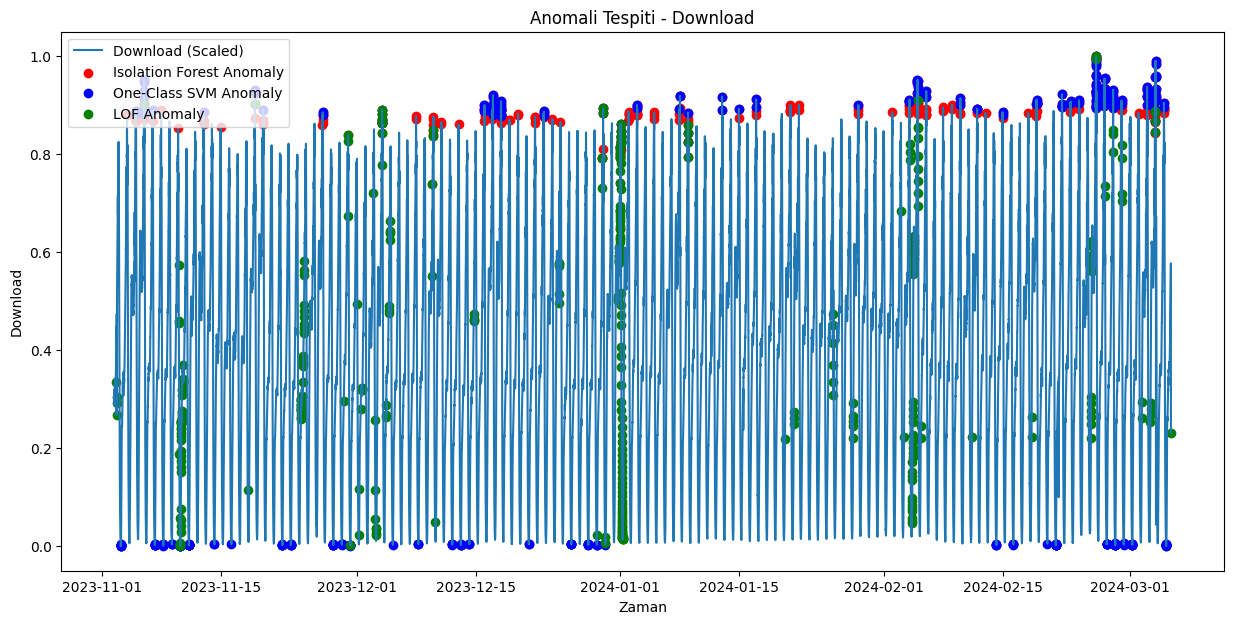

In [165]:
# Görselleştirme - Anomaliler
plt.figure(figsize=(15, 7))
plt.plot(data_complete.index, data_complete['DOWNLOAD'], label='Download (Scaled)')
plt.scatter(data_ml.index[data_ml['anomaly_if'] == 1], data_ml['DOWNLOAD'][data_ml['anomaly_if'] == 1], color='red', label='Isolation Forest Anomaly')
plt.scatter(data_ml.index[data_ml['anomaly_svm'] == 1], data_ml['DOWNLOAD'][data_ml['anomaly_svm'] == 1], color='blue', label='One-Class SVM Anomaly')
plt.scatter(data_ml.index[data_ml['anomaly_lof'] == 1], data_ml['DOWNLOAD'][data_ml['anomaly_lof'] == 1], color='green', label='LOF Anomaly')
plt.title('Anomali Tespiti - Download')
plt.xlabel('Zaman')
plt.ylabel('Download')
plt.legend()
plt.show()

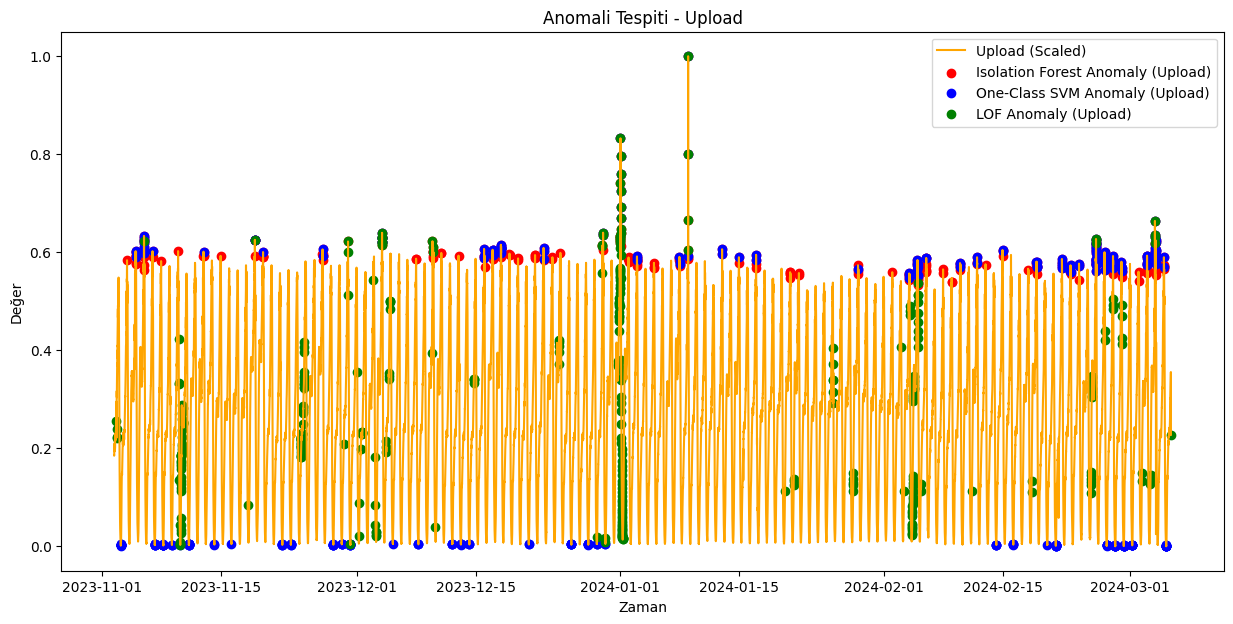

In [167]:
# Görselleştirme - Anomaliler
plt.figure(figsize=(15, 7))


# Upload verisi
plt.plot(data_complete.index, data_complete['UPLOAD'], label='Upload (Scaled)', color='orange')
plt.scatter(data_ml.index[data_ml['anomaly_if'] == 1], data_ml['UPLOAD'][data_ml['anomaly_if'] == 1], color='red',  label='Isolation Forest Anomaly (Upload)')
plt.scatter(data_ml.index[data_ml['anomaly_svm'] == 1], data_ml['UPLOAD'][data_ml['anomaly_svm'] == 1], color='blue',  label='One-Class SVM Anomaly (Upload)')
plt.scatter(data_ml.index[data_ml['anomaly_lof'] == 1], data_ml['UPLOAD'][data_ml['anomaly_lof'] == 1], color='green',  label='LOF Anomaly (Upload)')

plt.title('Anomali Tespiti - Upload')
plt.xlabel('Zaman')
plt.ylabel('Değer')
plt.legend()
plt.show()


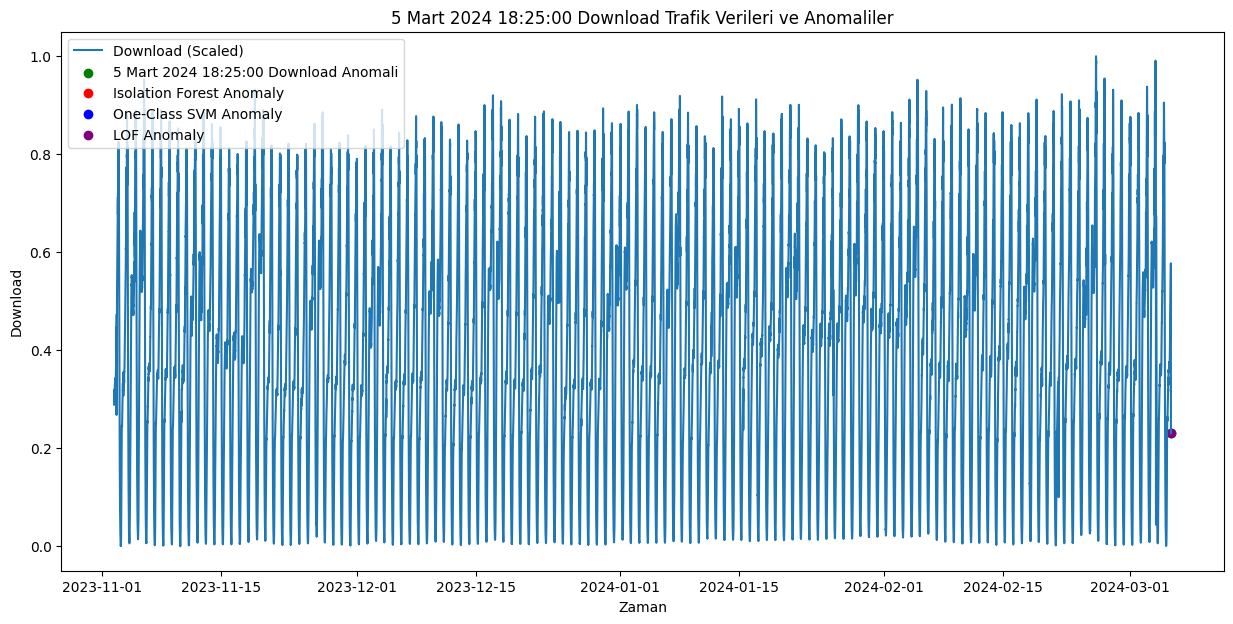

In [140]:
# Görselleştirme - Belirli Tarih ve Saat (Download)
plt.figure(figsize=(15, 7))
plt.plot(data_complete.index, data_complete['DOWNLOAD'], label='Download (Scaled)')
plt.scatter(data_ml.index[data_ml.index == specific_timestamp],
            data_complete['DOWNLOAD'][data_ml.index == specific_timestamp],
            color='green', label='5 Mart 2024 18:25:00 Download Anomali')
plt.scatter(data_ml.index[(data_ml.index == specific_timestamp) & (data_ml['anomaly_if'] == 1)],
            data_complete['DOWNLOAD'][(data_ml.index == specific_timestamp) & (data_ml['anomaly_if'] == 1)],
            color='red', label='Isolation Forest Anomaly')
plt.scatter(data_ml.index[(data_ml.index == specific_timestamp) & (data_ml['anomaly_svm'] == 1)],
            data_complete['DOWNLOAD'][(data_ml.index == specific_timestamp) & (data_ml['anomaly_svm'] == 1)],
            color='blue', label='One-Class SVM Anomaly')
plt.scatter(data_ml.index[(data_ml.index == specific_timestamp) & (data_ml['anomaly_lof'] == 1)],
            data_complete['DOWNLOAD'][(data_ml.index == specific_timestamp) & (data_ml['anomaly_lof'] == 1)],
            color='purple', label='LOF Anomaly')
plt.title('5 Mart 2024 18:25:00 Download Trafik Verileri ve Anomaliler')
plt.xlabel('Zaman')
plt.ylabel('Download')
plt.legend()
plt.show()


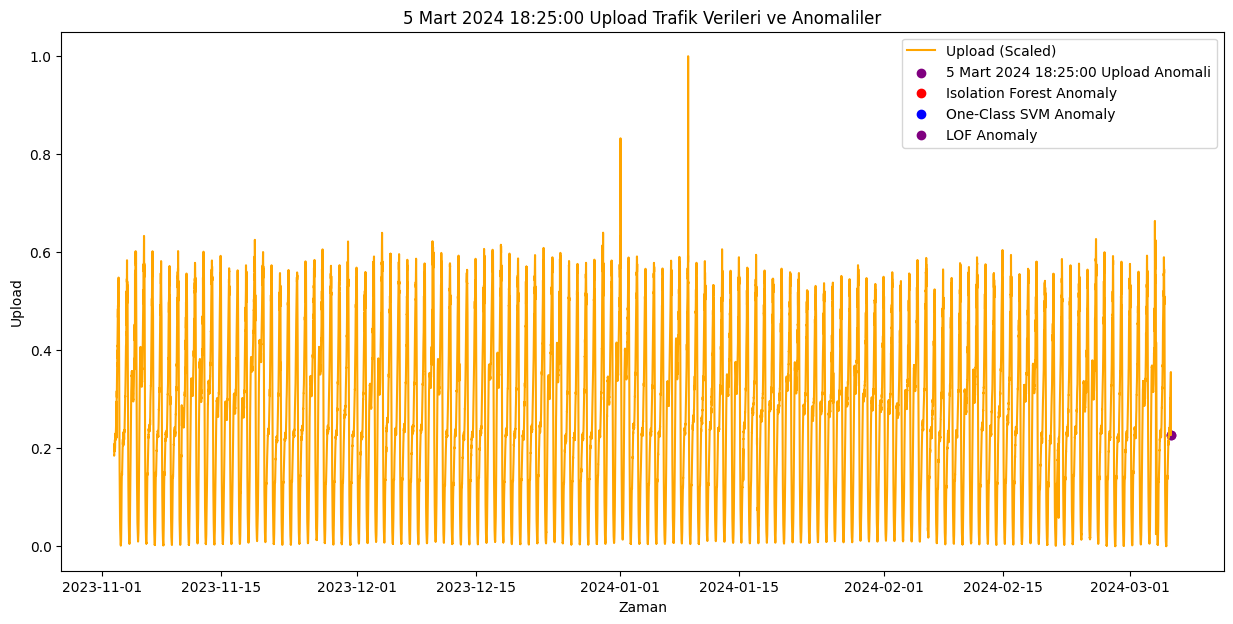

In [141]:
# Görselleştirme - Belirli Tarih ve Saat (Upload)
plt.figure(figsize=(15, 7))
plt.plot(data_complete.index, data_complete['UPLOAD'], label='Upload (Scaled)', color='orange')
plt.scatter(data_ml.index[data_ml.index == specific_timestamp],
            data_complete['UPLOAD'][data_ml.index == specific_timestamp],
            color='purple', label='5 Mart 2024 18:25:00 Upload Anomali')
plt.scatter(data_ml.index[(data_ml.index == specific_timestamp) & (data_ml['anomaly_if'] == 1)],
            data_complete['UPLOAD'][(data_ml.index == specific_timestamp) & (data_ml['anomaly_if'] == 1)],
            color='red', label='Isolation Forest Anomaly')
plt.scatter(data_ml.index[(data_ml.index == specific_timestamp) & (data_ml['anomaly_svm'] == 1)],
            data_complete['UPLOAD'][(data_ml.index == specific_timestamp) & (data_ml['anomaly_svm'] == 1)],
            color='blue', label='One-Class SVM Anomaly')
plt.scatter(data_ml.index[(data_ml.index == specific_timestamp) & (data_ml['anomaly_lof'] == 1)],
            data_complete['UPLOAD'][(data_ml.index == specific_timestamp) & (data_ml['anomaly_lof'] == 1)],
            color='purple', label='LOF Anomaly')
plt.title('5 Mart 2024 18:25:00 Upload Trafik Verileri ve Anomaliler')
plt.xlabel('Zaman')
plt.ylabel('Upload')
plt.legend()
plt.show()

SORU 2

In [142]:
# Zaman Serisi Tahmini - Prophet
prophet_data_download = data_complete[['DOWNLOAD']].reset_index()
prophet_data_download.columns = ['ds', 'y']

prophet_data_upload = data_complete[['UPLOAD']].reset_index()
prophet_data_upload.columns = ['ds', 'y']

In [143]:
# Prophet modelini oluşturma ve fit etme
model_download = Prophet()
model_upload = Prophet()

model_download.fit(prophet_data_download)
model_upload.fit(prophet_data_upload)

13:56:21 - cmdstanpy - INFO - Chain [1] start processing
13:56:34 - cmdstanpy - INFO - Chain [1] done processing
13:56:36 - cmdstanpy - INFO - Chain [1] start processing
13:56:47 - cmdstanpy - INFO - Chain [1] done processing


In [150]:
# Gelecekteki tarihleri oluşturma
future_download = model_download.make_future_dataframe(periods=30, freq='T')
future_upload = model_upload.make_future_dataframe(periods=30, freq='T')


In [151]:
# # Gelecekteki tarihleri oluşturma - 3 gün sonrası (4320 dakika = 3 gün)
# future_download = model_download.make_future_dataframe(periods=4320, freq='T')
# future_upload = model_upload.make_future_dataframe(periods=4320, freq='T')

In [152]:
forecast_download = model_download.predict(future_download)
forecast_upload = model_upload.predict(future_upload)

In [153]:
# Belirli Tarih ve Saat
specific_date = '2024-03-05'
specific_time = '18:25:00'
specific_datetime = f"{specific_date} {specific_time}"
specific_timestamp = pd.to_datetime(specific_datetime)

In [154]:
# Tahmin edilen ve gerçek değerler
actual_value_download = data_complete.loc[specific_timestamp, 'DOWNLOAD'] if specific_timestamp in data_complete.index else np.nan
actual_value_upload = data_complete.loc[specific_timestamp, 'UPLOAD'] if specific_timestamp in data_complete.index else np.nan

predicted_value_download = forecast_download.loc[forecast_download['ds'] == specific_timestamp, 'yhat'].values[0]
predicted_value_upload = forecast_upload.loc[forecast_upload['ds'] == specific_timestamp, 'yhat'].values[0]

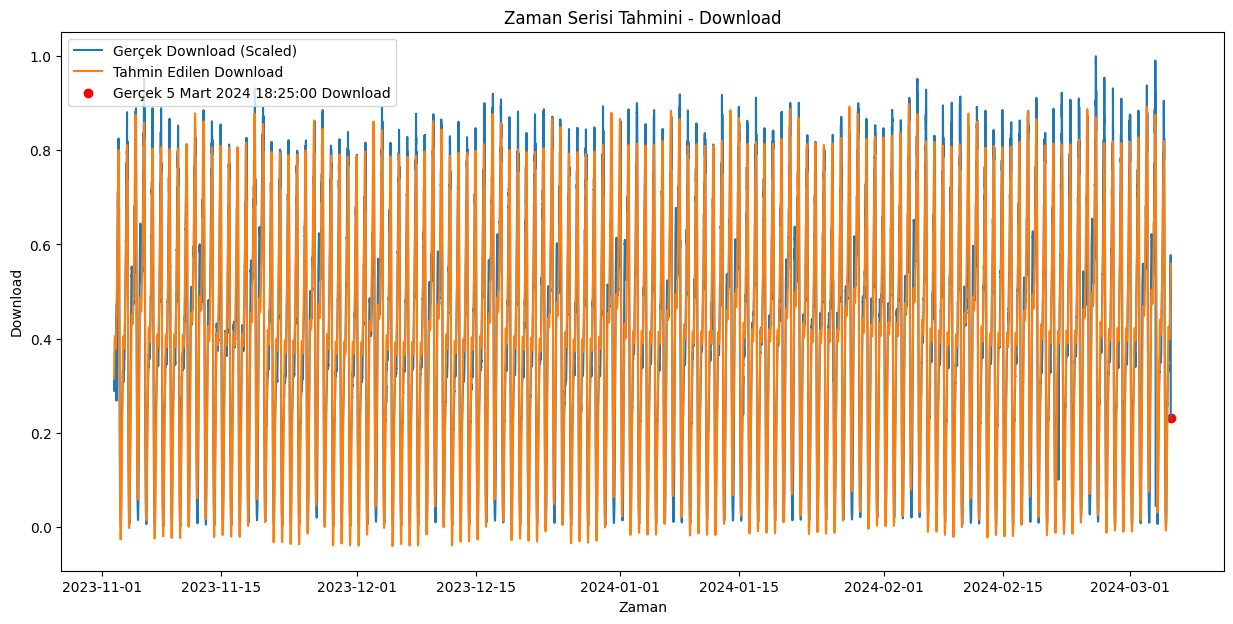

In [155]:
# Tahmin ve anomali görselleştirme
plt.figure(figsize=(15, 7))
plt.plot(data_complete.index, data_complete['DOWNLOAD'], label='Gerçek Download (Scaled)')
plt.plot(forecast_download['ds'], forecast_download['yhat'], label='Tahmin Edilen Download')
plt.scatter([specific_timestamp], [actual_value_download], color='red', label='Gerçek 5 Mart 2024 18:25:00 Download')
plt.title('Zaman Serisi Tahmini - Download')
plt.xlabel('Zaman')
plt.ylabel('Download')
plt.legend()
plt.show()

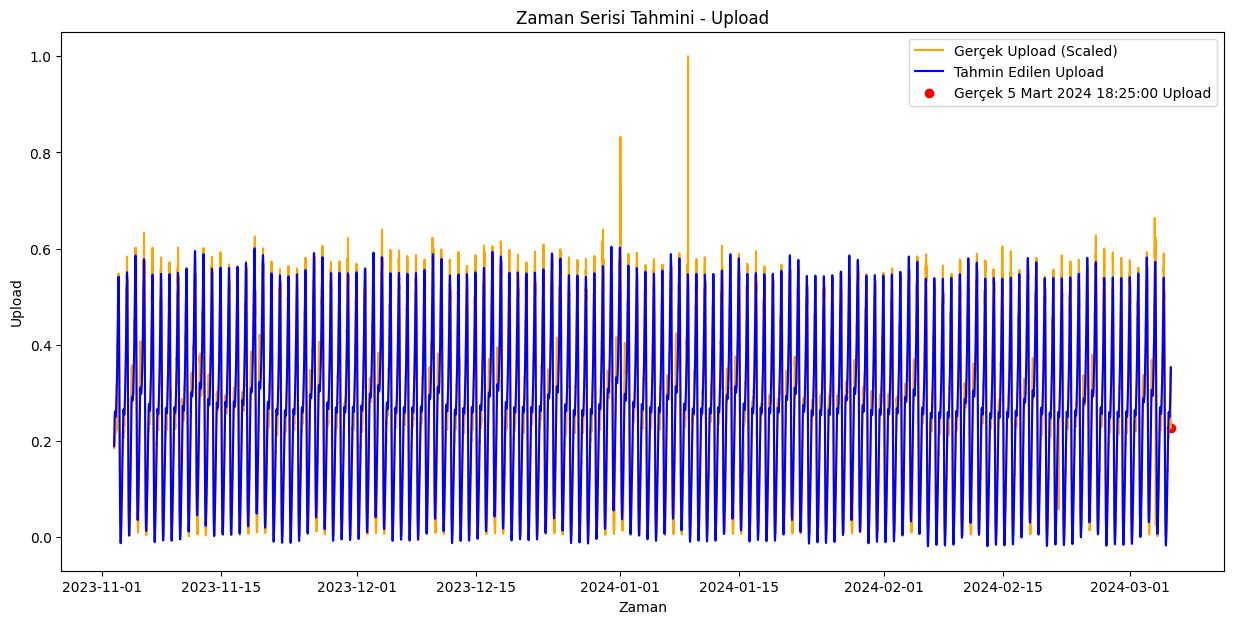

In [156]:
plt.figure(figsize=(15, 7))
plt.plot(data_complete.index, data_complete['UPLOAD'], label='Gerçek Upload (Scaled)', color='orange')
plt.plot(forecast_upload['ds'], forecast_upload['yhat'], label='Tahmin Edilen Upload', color='blue')
plt.scatter([specific_timestamp], [actual_value_upload], color='red', label='Gerçek 5 Mart 2024 18:25:00 Upload')
plt.title('Zaman Serisi Tahmini - Upload')
plt.xlabel('Zaman')
plt.ylabel('Upload')
plt.legend()
plt.show()


In [157]:
# Anomali Durumunu Belirleme
if np.isnan(actual_value_download) or np.isnan(predicted_value_download):
    anomaly_download = "Veri mevcut değil."
else:
    # Anomali belirleme (Tahmin aralığının dışında mı?)
    anomaly_download = "Anomali" if abs(actual_value_download - predicted_value_download) > 0.1 else "Normal"

if np.isnan(actual_value_upload) or np.isnan(predicted_value_upload):
    anomaly_upload = "Veri mevcut değil."
else:
    # Anomali belirleme (Tahmin aralığının dışında mı?)
    anomaly_upload = "Anomali" if abs(actual_value_upload - predicted_value_upload) > 0.1 else "Normal"

In [158]:
# Sonuçları Yazdırma
print(f"5 Mart 2024 18:25:00 saatindeki DOWNLOAD veri durumu: {anomaly_download}")
print(f"5 Mart 2024 18:25:00 saatindeki UPLOAD veri durumu: {anomaly_upload}")

5 Mart 2024 18:25:00 saatindeki DOWNLOAD veri durumu: Anomali
5 Mart 2024 18:25:00 saatindeki UPLOAD veri durumu: Anomali


In [178]:


# print(f"5 Mart 2024 18:25:00 saatindeki Tahmin Edilen DOWNLOAD: {predicted_value_download}")
# print(f"5 Mart 2024 18:25:00 saatindeki Tahmin Edilen UPLOAD: {predicted_value_upload}")

BONUS SORU

In [159]:
# Trafik Yoğunluğu Analizi - Saat Dilimlerine Göre Gruplama
hourly_traffic = data_complete.groupby('HOUR').agg({'DOWNLOAD': 'mean', 'UPLOAD': 'mean'}).reset_index()

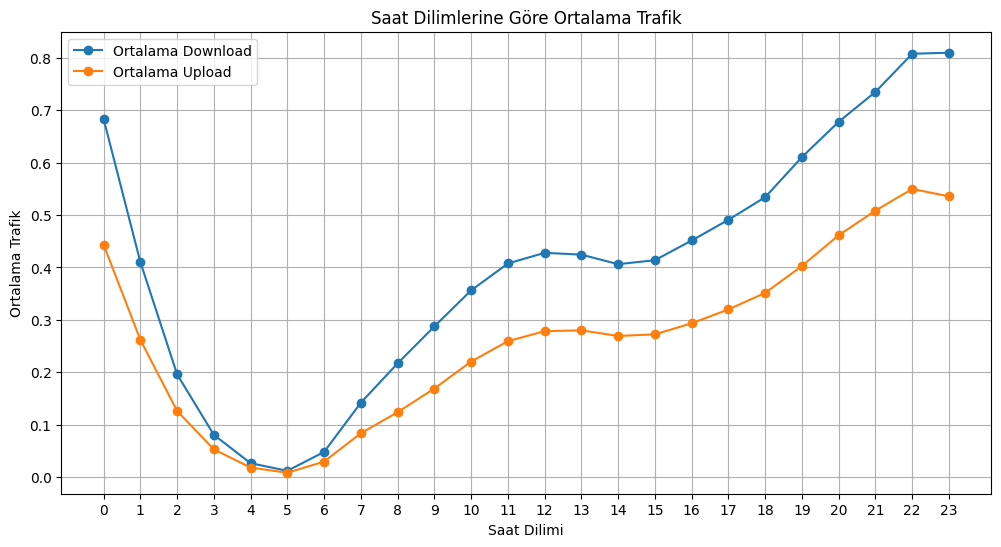

In [160]:
# Saat dilimlerine göre ortalama trafik miktarını görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(hourly_traffic['HOUR'], hourly_traffic['DOWNLOAD'], marker='o', label='Ortalama Download')
plt.plot(hourly_traffic['HOUR'], hourly_traffic['UPLOAD'], marker='o', label='Ortalama Upload')
plt.title('Saat Dilimlerine Göre Ortalama Trafik')
plt.xlabel('Saat Dilimi')
plt.ylabel('Ortalama Trafik')
plt.xticks(hourly_traffic['HOUR'])  
plt.legend()
plt.grid(True)
plt.show()